In [1]:
import os
import json
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from collections import OrderedDict, Counter

   
from collections import namedtuple


Genotype = namedtuple("Genotype", "normal normal_concat reduce reduce_concat")

In [302]:
BENCHMARKS = {
     'nasbench101': ['cifar10'],
    'nasbench201': ['cifar10', 'cifar100', 'ImageNet16-120'],
    'nasbench301': ['cifar10'],
    'transbench101_micro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic'],
    'transbench101_macro': ['jigsaw', 'class_scene', 'class_object', 'autoencoder', 'normal', 'room_layout', 'segmentsemantic']
}

LABELS = {
    'nasbench101': 'NB101',
    'nasbench201': 'NB201',
    'nasbench301': 'NB301',
    'transbench101_micro': 'TNB101_MICRO',
    'transbench101_macro': 'TNB101_MACRO',
    'cifar10': 'CF10',
    'cifar100': 'CF100',
    'ImageNet16-120': 'IMGNT',
    'jigsaw': 'JIGSAW',
    'class_scene': 'SCENE',
    'class_object': 'OBJECT',
    'autoencoder': 'AUTOENC',
    'normal': 'NORMAL',
    'room_layout': 'ROOM',
    'segmentsemantic': 'SEGMENT',
}

predictors = ['epe_nas', 'fisher', 'flops',
       'grad_norm', 'grasp', 'jacov', 'l2_norm', 'nwot', 'params', 'plain',
       'snip', 'synflow', 'zen']

benchmarks_abbv = {
    'nasbench101': 'nb101',
    'nasbench201': 'nb201',
    'nasbench301': 'nb301',
    'transbench101_macro': 'tnb101_macro',
    'transbench101_micro': 'tnb101_micro',
    
}

START_SEED=9000
END_SEED=9005

In [4]:
def get_all_files(root_folder='../naslib/data', filename='.json'):
    all_files = []
    for file in os.listdir(root_folder):
        if file.endswith(filename):
            all_files.append(os.path.join(root_folder, file))

    return all_files


In [5]:
get_all_files()

['../naslib/data/zc_nasbench301.json',
 '../naslib/data/zc_nasbench101.json',
 '../naslib/data/zc_nasbench201.json',
 '../naslib/data/zc_transbench101_macro.json',
 '../naslib/data/zc_transbench101_micro.json']

In [15]:
def get_arch_scores_acc(nas_benchmark, dataset='cifar10'):
    if nas_benchmark == 'nb101':
        with open('../naslib/data/zc_nasbench101.json', 'r') as f:
            raw_stats = json.load(f)
            stats = raw_stats['cifar10']
    elif nas_benchmark == 'nb201':
        with open('../naslib/data/zc_nasbench201.json', 'r') as f:
            stats = json.load(f)[dataset]
    elif nas_benchmark == 'nb301':
        with open('../naslib/data/zc_nasbench301.json', 'r') as f:
            stats = json.load(f)[dataset]
    elif nas_benchmark == 'tnb101_macro':
        with open('../naslib/data/zc_transbench101_macro.json', 'r') as f:
            stats = json.load(f)[dataset]
    elif nas_benchmark == 'tnb101_micro':
        with open('../naslib/data/zc_transbench101_micro.json', 'r') as f:
            stats = json.load(f)[dataset]      
    else:
        raise Exception('no exist')
    #archs = stats.keys()
    return stats

In [7]:
def get_predictor_score_dict(stats, predictor):
    score_dict = OrderedDict()
    for arch in stats.keys():
        score = stats[arch][predictor]['score']
        acc = stats[arch]['val_accuracy']
        score_dict[arch] = (score, acc)
    sorted_dict = OrderedDict(sorted(score_dict.items(), key=lambda x: x[1][0], reverse=True))

    return sorted_dict
        
        
    

In [126]:
all_ops_101 = ["input", "output", "maxpool3x3", "conv1x1-bn-relu", "conv3x3-bn-relu"]

def get_predictor_score_dict_101(stats, predictor):
    score_dict = OrderedDict()
    for arch in stats.keys():
        score = stats[arch][predictor]['score']
        acc = stats[arch]['val_accuracy']
        score_dict[arch] = (score, acc)

    sorted_dict = OrderedDict(sorted(score_dict.items(), key=lambda x: x[1][0], reverse=True))

    return sorted_dict

def convert_tuple_to_spec_101(tup):
    l = len(tup)
    # l = n*n + n
    n = int(-0.5 + np.sqrt(1 + 4*l)/2)
    matrix_vals = tup[:-n]
    matrix = np.array(matrix_vals).reshape(n, n)
    ops = [all_ops_101[t] for t in tup[-n:]]

    return {"matrix": matrix, "ops": ops}

def get_conv_over_pool_101(tup):
    l = len(tup)
    n = int(-0.5 + np.sqrt(1 + 4*l)/2)
    ops_counter = Counter(tup[-n:])
    conv_count = ops_counter[3] + ops_counter[4]
    pool_count = ops_counter[2]
    return conv_count - pool_count

def count_unique_101(tup):
    l = len(tup)
    n = int(-0.5 + np.sqrt(1 + 4*l)/2)
    return len(set(eval(tup)[-n:]))

In [62]:
def parse_tuple(str_tup):
    lst = str_tup[1:-1].split(',')
    int_list = [int(item) for item in lst]
    return int_list
    

In [118]:
def count_unique(tup):
    return len(set(eval(tup)))

In [195]:
stats = get_arch_scores_acc('nb201', 'cifar10')

In [127]:
synflow_dict = get_predictor_score_dict(stats, 'synflow')

In [46]:
def convert_tuple_to_str_201(tup):
    OP_NAMES_NB201 = ['skip_connect', 'none', 'nor_conv_3x3', 'nor_conv_1x1', 'avg_pool_3x3']
    op_list = [OP_NAMES_NB201[index] for index in parse_tuple(tup)]
    return "|{}|+|{}|{}|+|{}|{}|{}|".format(*op_list)

def convert_str_to_op_indices(str_encoding):
    """
    Converts NB201 string representation to op_indices
    """
    nodes = str_encoding.split('+')
    def get_op(x):
        return x.split('~')[0]

    node_ops = [list(map(get_op, n.strip()[1:-1].split('|'))) for n in nodes]

    enc = []
    for u, v in EDGE_LIST:
        enc.append(OP_NAMES_NB201.index(node_ops[v-2][u-1]))

    return tuple(enc)
    

In [312]:
def get_conv_over_pool_201(tup):
    ops_counter = Counter(tup)
    return ops_counter[2] + ops_counter[3] - ops_counter[4]

In [318]:
def calculate_cell_size_201(tup):
    ops_counter = Counter(tup)
    return len(tup) - ops_counter[1]


In [319]:
def get_num_skip_201(tup):
    ops_counter = Counter(tup)
    return ops_counter[0]

In [320]:
def get_filter_diff_201(tup):
    ops_counter = Counter(tup)
    return ops_counter[2] - ops_counter[3]

In [51]:
def convert_compact_to_genotype_301(compact):
    """Converts the compact representation to a Genotype"""
    OPS = [
        "max_pool_3x3",
        "avg_pool_3x3",
        "skip_connect",
        "sep_conv_3x3",
        "sep_conv_5x5",
        "dil_conv_3x3",
        "dil_conv_5x5",
    ]
    genotype = []

    for i in range(2):
        cell = compact[i]
        genotype.append([])

        for j in range(8):
            genotype[i].append((OPS[cell[j][1]], cell[j][0]))

    return Genotype(
        normal=genotype[0],
        normal_concat=[2, 3, 4, 5],
        reduce=genotype[1],
        reduce_concat=[2, 3, 4, 5],
    )

In [52]:
def convert_genotype_to_config_301(genotype):
    """Converts a DARTS genotype to a configspace instance dictionary"""
    base_string = "NetworkSelectorDatasetInfo:darts:"
    config = {}

    for cell_type in ["normal", "reduce"]:
        cell = eval("genotype." + cell_type)

        start = 0
        n = 2
        for node_idx in range(4):
            end = start + n
            ops = cell[2 * node_idx : 2 * node_idx + 2]

            # get edge idx
            edges = {
                base_string + "edge_" + cell_type + "_" + str(start + i): op
                for op, i in ops
            }
            config.update(edges)

            if node_idx != 0:
                # get node idx
                input_nodes = sorted(list(map(lambda x: x[1], ops)))
                input_nodes_idx = "_".join([str(i) for i in input_nodes])
                config.update(
                    {
                        base_string
                        + "inputs_node_"
                        + cell_type
                        + "_"
                        + str(node_idx + 2): input_nodes_idx
                    }
                )

            start = end
            n += 1
    return config

In [183]:
def get_num_skip_301(compact):
    count = 0 
    for i in range(2):
        cell = compact[i]
        for j in range(8):
            if cell[j][1] == 2:
                count += 1
    return count

In [184]:
def get_conv_over_pool_301(compact):
    count_conv = 0 
    count_pool = 0 
    for i in range(2):
        cell = compact[i]
        for j in range(8):
            if cell[j][1] < 2:
                count_pool += 1
            elif cell[j][1] > 2:
                count_conv += 1
            else:
                continue
    return count_conv-count_pool  

In [227]:
def get_filter_diff_301(compact):
    count_small = 0 
    count_large = 0 
    for i in range(2):
        cell = compact[i]
        for j in range(8):
            if cell[j][1] == 3 or cell[j][1] == 5:
                count_small += 1
            elif cell[j][1] == 4 or cell[j][1] == 6:
                count_large += 1
            else:
                continue
    return count_large-count_small 

In [242]:
def count_unique_301(compact):
    ops = []
    for i in range(2):
        cell = compact[i]
        for j in range(8):
            ops.append(cell[j][1])
    return len(set(ops))

In [31]:
stats_301 = get_arch_scores_acc('nb301')

In [32]:
len(stats_301)

11221

In [309]:
stats_301

{'(((0, 6), (1, 4), (0, 0), (1, 5), (1, 4), (3, 2), (0, 6), (3, 2)), ((0, 1), (1, 4), (0, 1), (1, 4), (2, 6), (3, 4), (1, 5), (2, 1)))': {'epe_nas': {'score': 1763.570303683912,
   'time': 2.7000158159062266},
  'fisher': {'score': 0.2787033021450043, 'time': 3.1504855030216277},
  'flops': {'score': 169.28512, 'time': 0.4158075680024922},
  'grad_norm': {'score': 54.20591735839844, 'time': 2.9809987638145685},
  'grasp': {'score': -1.0169639587402344, 'time': 13.765399944037199},
  'id': 0,
  'jacov': {'score': -64.94701312393762, 'time': 2.967228803783655},
  'l2_norm': {'score': 674.346435546875, 'time': 0.08961817901581526},
  'params': {'score': 0.963882, 'time': 0.41157804476097226},
  'plain': {'score': 0.08779452741146088, 'time': 2.856864394620061},
  'snip': {'score': 164.10951232910156, 'time': 2.9777091899886727},
  'synflow': {'score': 64.70201440326538, 'time': 0.9393863240256906},
  'val_accuracy': 93.45999908447266},
 '(((0, 4), (1, 5), (0, 6), (2, 2), (1, 0), (3, 5), (

In [308]:
def convert_op_indices_to_str_tnb_macro(op_indices):
    """
    Converts naslib object to string representation.
    """
    ops_string = ''.join([str(e) for e in op_indices if e!=0])
    return '64-{}-basic'.format(ops_string)

In [309]:
def convert_op_indices_to_str_tnb_micro(tup):
    ops_to_tb101 = {
        2: 'ReLUConvBN1x1',
        3: 'ReLUConvBN3x3',
        1: 'Identity',
        0: 'Zero',
    }

    op_edge_list = [ops_to_tb101[edge] for edge in tup]

    return '|{}|+|{}|{}|+|{}|{}|{}|'.format(*op_edge_list)

In [322]:
def calculate_cell_size_tnb101(tup):
    ops_counter = Counter(tup)
    return len(tup) - ops_counter[0]
    

In [321]:
def get_num_skip_tnb101(tup):
    ops_counter = Counter(tup)
    return ops_counter[1]

In [8]:
stats_tnb101_micro_dict = {}
for dataset in BENCHMARKS['transbench101_micro']:
    stats_tnb101_micro_dict[dataset] = get_arch_scores_acc('tnb101_micro', dataset)

In [290]:
stats_tnb101_normal = get_arch_scores_acc('tnb101_macro', 'normal')

In [57]:
def get_scores_as_df_201(stats):
    data = []

    for arch in stats.keys():
        record = stats[arch]
        data_item = {
            'id': record['id'],
            'arch': arch,
            'arch_str': convert_tuple_to_str_201(arch),
            'acc': record['val_accuracy'],
        }
        for pred in record.keys():
            if isinstance(record[pred], dict):
                data_item[pred] = record[pred]['score']

        data.append(data_item)

    return pd.DataFrame(data)

In [67]:
def get_scores_as_df_101(stats):
    data = []

    for arch in stats.keys():
        record = stats[arch]
        data_item = {
            'arch': arch,
            'conv_over_pool': get_conv_over_pool_101(eval(arch)),
            'acc': record['val_accuracy'],
        }
        for pred in record.keys():
            if isinstance(record[pred], dict):
                data_item[pred] = record[pred]['score']

        data.append(data_item)

    return pd.DataFrame(data)

In [169]:
def get_scores_as_df_301(stats):
    data = []

    for arch in stats.keys():
        record = stats[arch]
        data_item = {
            'arch': arch,
            'arch_str': convert_compact_to_genotype_301(eval(arch)),
            'acc': record['val_accuracy'],
            
        }
        for pred in record.keys():
            if isinstance(record[pred], dict):
                data_item[pred] = record[pred]['score']
        data.append(data_item)

    return pd.DataFrame(data)

In [307]:
def get_scores_as_df_tnb101(stats, ss_type='micro'):
    data = []

    for arch in stats.keys():
        record = stats[arch]
        data_item = {
            'id': record['id'],
            'arch': arch,
            'arch_str': convert_op_indices_to_str_tnb_micro(eval(arch)) if ss_type =='micro' else convert_op_indices_to_str_tnb_macro(eval(arch)),
            'acc': record['val_accuracy'],
        }
        for pred in record.keys():
            if isinstance(record[pred], dict):
                data_item[pred] = record[pred]['score']

        data.append(data_item)

    return pd.DataFrame(data)

In [68]:
stats_101 = get_arch_scores_acc('nb101')
print(convert_tuple_to_spec_101((0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 4, 4, 2, 1)))

df_101 = get_scores_as_df_101(stats_101)

{'matrix': array([[0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 1, 1],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]]), 'ops': ['input', 'conv1x1-bn-relu', 'maxpool3x3', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'maxpool3x3', 'output']}


In [69]:
df_101

,arch,conv_over_pool,acc,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen
0,"(0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",3,92.417866,386.571530,6.226621,1272.747008,70.826736,-3.013153,-32.210986,1190.241577,450.187981,8.555530,0.038781,457.200317,117.297104,125.265724
1,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",5,89.423078,460.591244,282.313782,870.159360,456.633606,486.000000,-32.216147,948.391296,446.660865,5.878154,0.011812,2263.890137,163.453775,95.873070
2,"(0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...",1,92.808491,473.236015,45.614437,564.941824,149.167496,-18.458252,-32.194136,844.848633,440.480466,3.729162,0.017046,861.475159,108.753032,82.749283
3,"(0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",1,91.055691,495.029567,103.225037,564.941824,315.204315,5.222656,-32.222317,844.742493,440.664677,3.729162,-0.010577,1401.932007,108.172632,81.203964
4,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...",1,89.913863,669.060520,10.127175,496.800768,76.559723,-2.439697,-32.169658,648.333862,432.931484,3.292298,-0.014697,406.143158,108.782002,72.954468
5,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ...",3,89.643431,417.753144,66.439842,1966.806016,185.418381,-16.104492,-32.236437,1046.310547,461.504813,13.290378,0.001236,1358.992920,146.656165,92.879219
6,"(0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, ...",-3,87.730366,560.131982,5.086506,727.094272,79.305717,-131.793976,-32.178258,998.966553,458.772434,4.541322,0.429200,554.231018,58.592668,97.675392
7,"(0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, ...",-1,92.748398,403.102671,15.968042,3153.597440,103.649460,-33.438416,-32.193536,1014.510803,458.043150,21.220234,0.177590,934.693359,103.815562,112.892365
8,"(0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",1,90.855366,422.361727,81.394508,373.225216,232.580643,-59.559570,-32.244043,566.161133,422.246768,2.479416,0.042957,997.206665,110.147655,68.087296
9,"(0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, ...",-1,89.703524,399.189178,1.443322,529.257472,32.705078,-5.607750,-32.167797,694.461975,432.288750,3.468426,0.092115,204.257629,65.582397,75.550331


In [170]:
df_301 = get_scores_as_df_301(stats_301)

In [334]:
eval(df_301['arch'].iloc[0])

(((0, 6), (1, 4), (0, 0), (1, 5), (1, 4), (3, 2), (0, 6), (3, 2)),
 ((0, 1), (1, 4), (0, 1), (1, 4), (2, 6), (3, 4), (1, 5), (2, 1)))

In [182]:
convert_compact_to_genotype_301(eval(df_301['arch'].iloc[0]))

Genotype(normal=[('dil_conv_5x5', 0), ('sep_conv_5x5', 1), ('max_pool_3x3', 0), ('dil_conv_3x3', 1), ('sep_conv_5x5', 1), ('skip_connect', 3), ('dil_conv_5x5', 0), ('skip_connect', 3)], normal_concat=[2, 3, 4, 5], reduce=[('avg_pool_3x3', 0), ('sep_conv_5x5', 1), ('avg_pool_3x3', 0), ('sep_conv_5x5', 1), ('dil_conv_5x5', 2), ('sep_conv_5x5', 3), ('dil_conv_3x3', 1), ('avg_pool_3x3', 2)], reduce_concat=[2, 3, 4, 5])

In [332]:
convert_genotype_to_config_301(convert_compact_to_genotype(eval(df_301['arch'].iloc[0])))

{'NetworkSelectorDatasetInfo:darts:edge_normal_0': 'dil_conv_5x5',
 'NetworkSelectorDatasetInfo:darts:edge_normal_1': 'sep_conv_5x5',
 'NetworkSelectorDatasetInfo:darts:edge_normal_12': 'skip_connect',
 'NetworkSelectorDatasetInfo:darts:edge_normal_2': 'max_pool_3x3',
 'NetworkSelectorDatasetInfo:darts:edge_normal_3': 'dil_conv_3x3',
 'NetworkSelectorDatasetInfo:darts:edge_normal_6': 'sep_conv_5x5',
 'NetworkSelectorDatasetInfo:darts:edge_normal_8': 'skip_connect',
 'NetworkSelectorDatasetInfo:darts:edge_normal_9': 'dil_conv_5x5',
 'NetworkSelectorDatasetInfo:darts:edge_reduce_0': 'avg_pool_3x3',
 'NetworkSelectorDatasetInfo:darts:edge_reduce_1': 'sep_conv_5x5',
 'NetworkSelectorDatasetInfo:darts:edge_reduce_10': 'dil_conv_3x3',
 'NetworkSelectorDatasetInfo:darts:edge_reduce_11': 'avg_pool_3x3',
 'NetworkSelectorDatasetInfo:darts:edge_reduce_2': 'avg_pool_3x3',
 'NetworkSelectorDatasetInfo:darts:edge_reduce_3': 'sep_conv_5x5',
 'NetworkSelectorDatasetInfo:darts:edge_reduce_7': 'dil_con

In [75]:
stats_201_c100 = get_arch_scores_acc('nb201', 'cifar100')

df_201_c100 = get_scores_as_df_201(stats_201_c100)

In [76]:
df_201_c100

,id,arch,arch_str,acc,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen
0,0,"(4, 0, 3, 1, 4, 3)",|avg_pool_3x3|+|skip_connect|nor_conv_1x1|+|no...,63.32,1.485833e+02,0.038418,19.254592,13.409241,3.861117,-7.609252e+01,133.965576,752.606853,0.135156,0.082917,31.196325,46.801170,6.346962e+01
1,1,"(2, 4, 0, 0, 3, 2)",|nor_conv_3x3|+|avg_pool_3x3|skip_connect|+|sk...,71.16,2.276038e+02,0.025482,85.241152,13.362378,2.760572,-6.523923e+01,184.252441,784.386058,0.593236,0.048952,24.916412,87.607953,1.158110e+02
2,2,"(2, 0, 3, 1, 4, 1)",|nor_conv_3x3|+|skip_connect|nor_conv_1x1|+|no...,67.24,1.624223e+02,0.157056,49.421632,26.527479,2.998028,-6.609234e+01,133.820404,761.511938,0.350196,0.175916,54.923988,54.151116,5.041497e+01
3,3,"(0, 0, 2, 1, 2, 3)",|skip_connect|+|skip_connect|nor_conv_3x3|+|no...,67.88,1.778774e+02,0.117992,83.950912,30.107895,8.050945,-6.520958e+01,184.699341,787.610557,0.593236,0.043785,61.887138,62.524491,9.276620e+01
4,4,"(4, 4, 1, 2, 1, 1)",|avg_pool_3x3|+|avg_pool_3x3|none|+|nor_conv_3...,1.00,-1.000000e+08,0.000043,46.349632,0.000000,0.000000,-1.000000e+08,82.694527,552.019140,0.322196,0.000000,0.000000,0.000000,-1.000000e+08
5,5,"(2, 1, 0, 1, 3, 0)",|nor_conv_3x3|+|none|skip_connect|+|none|nor_c...,69.22,2.173759e+02,0.019648,48.131392,8.624731,2.225717,-6.516040e+01,133.616745,762.638719,0.350196,0.059393,18.146852,66.542721,6.891687e+01
6,6,"(0, 4, 1, 1, 1, 0)",|skip_connect|+|avg_pool_3x3|none|+|none|none|...,46.82,7.135239e+01,0.042142,9.239872,7.429070,1.796736,-3.310905e+02,31.675745,608.711413,0.079156,0.254835,17.335850,17.066926,8.126110e+00
7,7,"(4, 1, 3, 3, 3, 3)",|avg_pool_3x3|+|none|nor_conv_1x1|+|nor_conv_1...,66.02,1.452093e+02,0.188156,26.688832,36.910995,50.923512,-7.526425e+01,235.683197,803.258411,0.191156,-0.002377,78.974419,58.075161,6.687476e+01
8,8,"(3, 1, 2, 3, 2, 3)",|nor_conv_1x1|+|none|nor_conv_3x3|+|nor_conv_1...,68.40,1.188220e+02,8.625135,92.675392,208.014755,339.489868,-6.514083e+01,286.788574,820.450302,0.649236,0.071654,444.042603,79.052366,1.022297e+02
9,9,"(3, 0, 1, 0, 3, 3)",|nor_conv_1x1|+|skip_connect|none|+|skip_conne...,63.30,1.823194e+02,1.385620,21.036352,88.887970,123.244385,-6.499574e+01,184.443878,788.681467,0.163156,0.027501,126.646408,62.878075,5.351573e+01


In [63]:
stats_201_c10 = get_arch_scores_acc('nb201', 'cifar10')

df_201_c10 = get_scores_as_df_201(stats_201_c10)

In [64]:
df_201_c10

,id,arch,arch_str,acc,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen
0,0,"(4, 0, 3, 1, 4, 3)",|avg_pool_3x3|+|skip_connect|nor_conv_1x1|+|no...,84.99,1.283299e+03,0.036440,19.248832,10.883215,0.244735,-8.828987e+01,130.200516,754.684333,0.129306,0.033875,22.923178,44.484811,6.338789e+01
1,1,"(2, 4, 0, 0, 3, 2)",|nor_conv_3x3|+|avg_pool_3x3|skip_connect|+|sk...,90.52,1.712861e+03,0.023383,85.235392,12.691692,2.205327,-6.519331e+01,180.487396,785.622961,0.587386,0.079539,26.610859,85.295247,1.194933e+02
2,2,"(2, 0, 3, 1, 4, 1)",|nor_conv_3x3|+|skip_connect|nor_conv_1x1|+|no...,88.40,1.640786e+03,0.115457,49.415872,20.088593,7.878273,-6.615395e+01,130.055359,762.608594,0.344346,0.119368,44.178249,51.838876,4.996934e+01
3,3,"(0, 0, 2, 1, 2, 3)",|skip_connect|+|skip_connect|nor_conv_3x3|+|no...,88.32,1.892559e+03,0.091167,83.945152,24.872454,12.207823,-6.528531e+01,180.934311,788.917398,0.587386,0.077502,51.889561,60.212156,9.266997e+01
4,4,"(4, 4, 1, 2, 1, 1)",|avg_pool_3x3|+|avg_pool_3x3|none|+|nor_conv_3...,10.00,-1.000000e+08,0.000013,46.343872,0.000000,0.000000,-1.000000e+08,78.929459,557.408140,0.316346,0.000000,0.000000,0.000000,-1.000000e+08
5,5,"(2, 1, 0, 1, 3, 0)",|nor_conv_3x3|+|none|skip_connect|+|none|nor_c...,90.68,1.716024e+03,0.016912,48.125632,8.115552,1.982712,-6.528345e+01,129.851685,764.678335,0.344346,0.121621,16.491257,64.232533,6.874727e+01
6,6,"(0, 4, 1, 1, 1, 0)",|skip_connect|+|avg_pool_3x3|none|+|none|none|...,70.87,8.212055e+02,0.043805,9.234112,7.375758,-0.250129,-3.239855e+02,27.910686,613.474219,0.073306,0.211128,13.997645,14.751044,8.298363e+00
7,7,"(4, 1, 3, 3, 3, 3)",|avg_pool_3x3|+|none|nor_conv_1x1|+|nor_conv_1...,87.35,1.379897e+03,0.161322,26.683072,41.271332,23.266205,-7.871433e+01,231.918152,803.910385,0.185306,0.159051,68.328522,55.762511,6.695525e+01
8,8,"(3, 1, 2, 3, 2, 3)",|nor_conv_1x1|+|none|nor_conv_3x3|+|nor_conv_1...,88.94,1.591668e+03,2.919859,92.669632,194.829361,352.838989,-6.519380e+01,283.023499,820.626852,0.643386,0.146713,300.757782,76.735830,1.031203e+02
9,9,"(3, 0, 1, 0, 3, 3)",|nor_conv_1x1|+|skip_connect|none|+|skip_conne...,85.67,1.569463e+03,0.756821,21.030592,76.180679,41.821884,-6.516971e+01,180.678848,788.867168,0.157306,0.037230,118.372742,60.554358,5.362846e+01


In [70]:
stats_nb201_imgnet = get_arch_scores_acc('nb201', 'ImageNet16-120')

In [73]:
df_201_IN = get_scores_as_df_201(stats_nb201_imgnet)

In [74]:
df_201_IN

,id,arch,arch_str,acc,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen
0,0,"(4, 0, 3, 1, 4, 3)",|avg_pool_3x3|+|skip_connect|nor_conv_1x1|+|no...,32.700000,2.170286e+01,0.070687,4.820032,18.253445,5.011692,-7.899137e+01,134.605103,660.687896,0.136456,0.072917,35.541744,46.628538,6.473771e+01
1,1,"(2, 4, 0, 0, 3, 2)",|nor_conv_3x3|+|avg_pool_3x3|skip_connect|+|sk...,44.233333,1.829335e+01,0.037853,21.316672,17.834019,6.955973,-6.978332e+01,185.025970,693.029305,0.594536,0.065186,33.967125,85.301660,1.190753e+02
2,2,"(2, 0, 3, 1, 4, 1)",|nor_conv_3x3|+|skip_connect|nor_conv_1x1|+|no...,38.566667,2.567565e+01,0.257575,12.361792,36.852112,16.467323,-7.140677e+01,134.303833,673.144394,0.351496,0.073207,78.996857,53.063710,4.857847e+01
3,3,"(0, 0, 2, 1, 2, 3)",|skip_connect|+|skip_connect|nor_conv_3x3|+|no...,40.600000,1.996656e+01,0.157729,20.994112,46.236378,12.789398,-6.980649e+01,185.178391,696.543445,0.594536,0.078214,89.410278,61.254452,9.043706e+01
4,4,"(4, 4, 1, 2, 1, 1)",|avg_pool_3x3|+|avg_pool_3x3|none|+|nor_conv_3...,0.833333,-1.000000e+08,0.000051,11.593792,0.000000,0.000000,-1.000000e+08,83.293434,448.956617,0.323496,0.000000,0.000000,0.000000,-1.000000e+08
5,5,"(2, 1, 0, 1, 3, 0)",|nor_conv_3x3|+|none|skip_connect|+|none|nor_c...,42.600000,3.013566e+01,0.041602,12.039232,14.439691,8.151206,-7.006703e+01,134.185104,669.742315,0.351496,0.095921,31.297827,65.095962,6.655309e+01
6,6,"(0, 4, 1, 1, 1, 0)",|skip_connect|+|avg_pool_3x3|none|+|none|none|...,15.166667,1.605630e+01,0.068417,2.316352,9.148326,2.862100,-1.547219e+03,32.315277,510.154227,0.080456,0.134811,21.537071,16.888818,7.087882e+00
7,7,"(4, 1, 3, 3, 3, 3)",|avg_pool_3x3|+|none|nor_conv_1x1|+|nor_conv_1...,37.100000,3.666733e+01,0.819509,6.678592,91.455307,48.207291,-8.817633e+01,236.050980,713.494894,0.192456,0.277429,138.390427,57.774139,6.620977e+01
8,8,"(3, 1, 2, 3, 2, 3)",|nor_conv_1x1|+|none|nor_conv_3x3|+|nor_conv_1...,42.200000,1.784025e+01,32.898037,23.175232,588.801575,13402.010742,-6.983015e+01,287.153412,729.682682,0.650536,0.191222,1029.932739,78.250477,9.987734e+01
9,9,"(3, 0, 1, 0, 3, 3)",|nor_conv_1x1|+|skip_connect|none|+|skip_conne...,33.933333,1.762228e+01,3.048352,5.265472,156.898376,360.683838,-6.971657e+01,184.841782,699.454020,0.164456,-0.121893,317.416962,62.545843,5.260981e+01


In [81]:
df_tnb101_micro_jig = get_scores_as_df_tnb101(stats_tnb101_micro_dict['jigsaw'])

In [266]:
len(df_tnb101_micro_auto)

4096

In [260]:
df_tnb101_micro_norm = get_scores_as_df_tnb101(stats_tnb101_micro_dict['normal'])

In [265]:
df_tnb101_micro_auto = get_scores_as_df_tnb101(stats_tnb101_micro_dict['autoencoder'])

In [228]:
['fisher', 'synflow', 'grad_norm', 'plain', 'grasp', 'snip', 'jacov']

['fisher', 'synflow', 'grad_norm', 'plain', 'grasp', 'snip', 'jacov']

In [239]:
['epe_nas', 'flops', 'l2_norm', 'nwot', 'params']

['epe_nas', 'flops', 'l2_norm', 'nwot', 'params']

# Architecture bias (start with nb201)

In [84]:
for predictor in predictors:
    print(predictor)
    print()
    for dataset in BENCHMARKS['nasbench201']:
        stats = get_arch_scores_acc('nb201', dataset)
        score_dict = get_predictor_score_dict(stats, predictor)
        tup = list(score_dict)[0]
        arch_str = convert_tuple_to_str_201(tup)
        print(dataset)
        print(arch_str)
    print()

    

epe_nas

cifar10
|skip_connect|+|none|nor_conv_1x1|+|none|nor_conv_1x1|nor_conv_3x3|
cifar100
|nor_conv_1x1|+|none|none|+|none|nor_conv_1x1|skip_connect|
ImageNet16-120
|nor_conv_3x3|+|nor_conv_3x3|skip_connect|+|none|nor_conv_1x1|none|

fisher

cifar10
|nor_conv_1x1|+|none|none|+|nor_conv_1x1|none|nor_conv_1x1|
cifar100
|nor_conv_1x1|+|none|none|+|nor_conv_1x1|none|nor_conv_1x1|
ImageNet16-120
|nor_conv_1x1|+|none|none|+|nor_conv_3x3|none|nor_conv_1x1|

flops

cifar10
|nor_conv_3x3|+|nor_conv_3x3|nor_conv_3x3|+|nor_conv_3x3|nor_conv_3x3|nor_conv_3x3|
cifar100
|nor_conv_3x3|+|nor_conv_3x3|nor_conv_3x3|+|nor_conv_3x3|nor_conv_3x3|nor_conv_3x3|
ImageNet16-120
|nor_conv_3x3|+|nor_conv_3x3|nor_conv_3x3|+|nor_conv_3x3|nor_conv_3x3|nor_conv_3x3|

grad_norm

cifar10
|nor_conv_1x1|+|none|none|+|nor_conv_1x1|none|nor_conv_1x1|
cifar100
|nor_conv_1x1|+|none|none|+|nor_conv_1x1|none|nor_conv_1x1|
ImageNet16-120
|nor_conv_1x1|+|none|none|+|nor_conv_3x3|none|nor_conv_3x3|

grasp

cifar10
|nor_conv_

####  flops, l2_norm, nwot, params, and synflow prefer all conv architectures

#### fisher, grasp, snip share similar topology (with nodes) and preference for conv 

## check for bias on TNB101 Micro

In [88]:
df_tnb101_micro_jig

,id,arch,arch_str,acc,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,zen
0,0,"(2, 3, 2, 3, 2, 3)",|ReLUConvBN1x1|+|ReLUConvBN3x3|ReLUConvBN1x1|+...,91.291801,183.998138,296.073728,429.621094,-8.857910,-3.202164e+01,1277.869995,480.794590,26.949640,0.100908,3798.486328,1.830817e+02
1,1,"(3, 1, 1, 2, 1, 2)",|ReLUConvBN3x3|+|Identity|Identity|+|ReLUConvB...,91.490845,20.712051,112.136704,121.878647,1.080505,-3.202141e+01,742.779846,462.471045,12.469000,0.262745,1047.132568,1.043993e+02
2,2,"(0, 0, 2, 1, 2, 3)",|Zero|+|Zero|ReLUConvBN1x1|+|Identity|ReLUConv...,58.927151,0.735040,127.836672,16.073116,-0.003698,-3.384792e+01,784.451294,397.624106,14.189320,-0.043339,57.273888,-1.352924e+01
3,3,"(3, 3, 3, 3, 0, 0)",|ReLUConvBN3x3|+|ReLUConvBN3x3|ReLUConvBN3x3|+...,94.237663,4.655445,346.085888,48.133606,-0.491501,-3.202625e+01,840.628296,468.238042,30.674952,0.060616,400.140533,1.310075e+02
4,4,"(2, 1, 0, 1, 3, 0)",|ReLUConvBN1x1|+|Identity|Zero|+|Identity|ReLU...,90.485672,9.981820,117.262848,78.216660,0.575012,-3.204632e+01,644.056335,452.866524,13.334024,0.028796,691.580444,8.081054e+01
5,5,"(1, 0, 2, 0, 3, 1)",|Identity|+|Zero|ReLUConvBN1x1|+|Zero|ReLUConv...,92.102905,16.176115,117.191168,106.795715,2.767761,-3.201876e+01,565.740845,448.043852,13.332232,0.143330,877.057251,7.407603e+01
6,6,"(2, 1, 1, 3, 2, 3)",|ReLUConvBN1x1|+|Identity|Identity|+|ReLUConvB...,90.634956,72.568520,206.668288,235.271027,-2.266357,-3.202102e+01,961.233948,470.588521,20.141832,0.225466,2116.440918,1.357888e+02
7,7,"(3, 1, 2, 3, 2, 3)",|ReLUConvBN3x3|+|Identity|ReLUConvBN1x1|+|ReLU...,94.262543,114.142227,288.616960,307.588074,5.264160,-3.201927e+01,1179.818359,475.215492,26.438408,0.214359,2933.111816,1.668948e+02
8,8,"(1, 3, 2, 2, 3, 1)",|Identity|+|ReLUConvBN3x3|ReLUConvBN1x1|+|ReLU...,92.287025,26.955603,206.668288,177.734940,-2.950439,-3.203213e+01,961.162109,468.624692,20.141832,0.257587,1514.647095,1.419199e+02
9,9,"(3, 0, 1, 0, 3, 3)",|ReLUConvBN3x3|+|Zero|Identity|+|Zero|ReLUConv...,83.165802,196.358261,279.837184,384.580078,51.158203,-3.203177e+01,663.506653,457.541180,26.098696,-0.007818,3385.330566,1.069126e+02


In [92]:
for dataset in BENCHMARKS['transbench101_micro']:
    print()
    print(dataset)
    print()
    #if dataset == 'jigsaw' or dataset =='autoencoder' or dataset =='normal' or dataset =='room_layout' \
    #    or dataset == 'segmentsemantic':
    #    continue
    stats = stats_tnb101_micro_dict[dataset]
    for predictor in predictors:
        if predictor == 'synflow' or predictor == 'epe_nas':
            continue 
        print(predictor)
        score_dict = get_predictor_score_dict(stats, predictor)
        tup = list(score_dict)[0]
        arch_str = convert_op_indices_to_str_tnb(eval(tup))
        print(arch_str)
    


jigsaw

fisher
|ReLUConvBN3x3|+|Zero|ReLUConvBN1x1|+|Zero|Zero|ReLUConvBN1x1|
flops
|ReLUConvBN3x3|+|ReLUConvBN3x3|ReLUConvBN3x3|+|ReLUConvBN3x3|ReLUConvBN3x3|ReLUConvBN3x3|
grad_norm
|ReLUConvBN1x1|+|Zero|ReLUConvBN1x1|+|Zero|Zero|ReLUConvBN1x1|
grasp
|ReLUConvBN1x1|+|ReLUConvBN3x3|ReLUConvBN1x1|+|Zero|Zero|ReLUConvBN1x1|
jacov
|Identity|+|ReLUConvBN3x3|ReLUConvBN3x3|+|ReLUConvBN1x1|ReLUConvBN1x1|ReLUConvBN1x1|
l2_norm
|ReLUConvBN1x1|+|ReLUConvBN1x1|ReLUConvBN1x1|+|ReLUConvBN3x3|ReLUConvBN3x3|ReLUConvBN1x1|
nwot
|ReLUConvBN1x1|+|ReLUConvBN1x1|ReLUConvBN3x3|+|ReLUConvBN3x3|ReLUConvBN1x1|ReLUConvBN1x1|
params
|ReLUConvBN3x3|+|ReLUConvBN3x3|ReLUConvBN3x3|+|ReLUConvBN3x3|ReLUConvBN3x3|ReLUConvBN3x3|
plain
|Identity|+|Identity|Identity|+|Identity|Identity|Identity|
snip
|ReLUConvBN3x3|+|Zero|ReLUConvBN1x1|+|Zero|Zero|ReLUConvBN3x3|
zen
|ReLUConvBN3x3|+|ReLUConvBN3x3|ReLUConvBN3x3|+|ReLUConvBN3x3|ReLUConvBN3x3|ReLUConvBN3x3|

class_scene

fisher
|ReLUConvBN3x3|+|Zero|ReLUConvBN3x3|+|Zero|Z

####  flops, l2_norm, nwot, params, and zen prefer all conv architectures



## check for bias on NB101

In [100]:
for predictor in predictors:
    print(predictor)
    #if predictor == 'nwot':
    #    continue
    score_dict_101 = get_predictor_score_dict_101(stats_101, predictor)
    tup = list(score_dict_101)[0]
    arch_str = convert_tuple_to_spec_101(eval(tup))
    print(arch_str['ops'])

epe_nas
['input', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'output']
fisher
['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'output']
flops
['input', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'output']
grad_norm
['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'output']
grasp
['input', 'conv3x3-bn-relu', 'conv3x3-bn-relu', 'maxpool3x3', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'output']
jacov
['input', 'maxpool3x3', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'output']
l2_norm
['input', 'conv1x1-bn-relu', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'output']
nwot
['input', 'conv3x3-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'conv1x1-bn-relu', 'output']
params
['input', 'conv3x3-bn-relu'

#### most proxies prefer all conv architectures, no pooling

#### plain grasp jacob_cov not in this list, only plain has >1 non-conv op

# conv/pool biases

In [313]:
df_201_c10['conv_over_pool'] = df_201_c10['arch'].apply(lambda x: get_conv_over_pool_201(eval(x)))

df_201_c10.corr().iloc[-1].sort_values(ascending=False)

num_skip          1.000000e+00
cell_size         2.500000e-01
zen               8.771432e-02
epe_nas           8.770929e-02
jacov             8.769609e-02
nwot              5.460198e-02
plain             4.978586e-02
acc               1.201167e-02
diversity         2.988554e-16
large_kernel      2.362089e-17
id               -4.029375e-03
grasp            -1.423492e-02
fisher           -4.836114e-02
conv_over_pool   -1.336306e-01
synflow          -1.418694e-01
grad_norm        -2.627739e-01
snip             -2.825913e-01
params           -2.851950e-01
flops            -2.993379e-01
l2_norm          -4.082308e-01
Name: num_skip, dtype: float64

In [112]:
df_201_c100['conv_over_pool'] = df_201_c100['arch'].apply(lambda x: get_conv_over_pool_201(eval(x)))

df_201_c100.corr().iloc[-1].sort_values(ascending=False)

conv_over_pool    1.000000
l2_norm           0.872880
params            0.609773
flops             0.590233
synflow           0.530923
acc               0.496014
snip              0.369943
grad_norm         0.348386
nwot              0.060174
jacov             0.046929
epe_nas           0.046887
zen               0.046886
fisher            0.036347
id                0.012609
grasp             0.007177
plain            -0.293362
Name: conv_over_pool, dtype: float64

In [314]:
df_201_IN['conv_over_pool'] = df_201_IN['arch'].apply(lambda x: get_conv_over_pool_201(eval(x)))

df_201_IN.corr().iloc[-1].sort_values(ascending=False)

diversity         1.000000e+00
acc               2.273755e-01
jacov             1.384848e-01
epe_nas           1.383541e-01
zen               1.383537e-01
nwot              1.179073e-01
plain             5.608936e-02
synflow           4.790448e-02
id                5.585579e-03
grasp             1.288988e-04
conv_over_pool    3.273691e-16
num_skip          2.988554e-16
cell_size         2.222214e-16
params            1.221709e-16
flops             2.699724e-17
large_kernel     -2.368036e-17
l2_norm          -7.762926e-07
fisher           -4.794477e-02
snip             -1.101845e-01
grad_norm        -1.134265e-01
Name: diversity, dtype: float64

In [192]:
df_301['conv_over_pool']= df_301['arch'].apply(lambda x: get_conv_over_pool_301(eval(x)))
df_301.corr()['conv_over_pool'].sort_values(ascending=False)

conv_over_pool    1.000000
nwot              0.782898
params            0.781374
l2_norm           0.764326
zen               0.747472
flops             0.704665
acc               0.452758
synflow           0.411265
grasp             0.284534
grad_norm         0.272833
snip              0.271860
fisher            0.010065
epe_nas          -0.023148
jacov            -0.113337
num_skip         -0.128180
plain            -0.445725
Name: conv_over_pool, dtype: float64

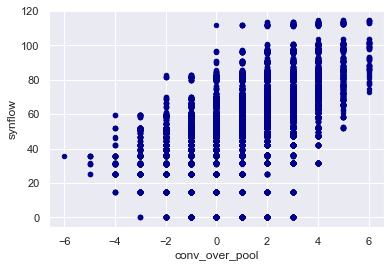

In [289]:
ax1 = df_201.plot.scatter(x='conv_over_pool', y='synflow', c='DarkBlue')

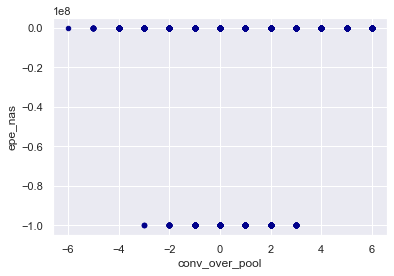

In [292]:
ax2 = df_201.plot.scatter(x='conv_over_pool', y='epe_nas', c='DarkBlue')

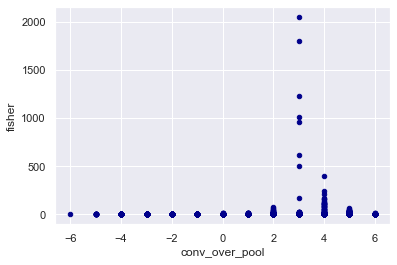

In [293]:
ax3 = df_201.plot.scatter(x='conv_over_pool', y='fisher', c='DarkBlue')

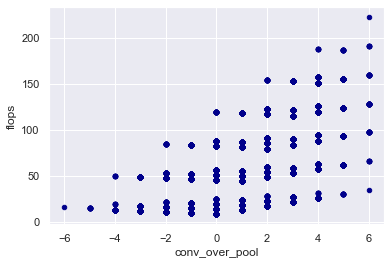

In [294]:
ax4 = df_201.plot.scatter(x='conv_over_pool', y='flops', c='DarkBlue')

In [117]:
df_101.corr().iloc[0].sort_values(ascending=False)

conv_over_pool    1.000000
synflow           0.755531
zen               0.631344
l2_norm           0.620150
nwot              0.437581
params            0.262481
flops             0.258456
grad_norm         0.237512
snip              0.210009
acc               0.208353
fisher            0.063015
grasp            -0.013327
epe_nas          -0.033172
plain            -0.367970
jacov            -0.454645
Name: conv_over_pool, dtype: float64

# zero nodes / cell size

In [286]:
df_301

,arch,arch_str,acc,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen,num_skip,conv_over_pool,large_kernel,diversity
0,"(((0, 6), (1, 4), (0, 0), (1, 5), (1, 4), (3, ...","([(dil_conv_5x5, 0), (sep_conv_5x5, 1), (max_p...",93.459999,1763.570304,0.278703,169.285120,54.205917,-1.016964,-64.947013,674.346436,892.207239,0.963882,0.087795,164.109512,64.702014,167.305389,2,6,6,6
1,"(((0, 4), (1, 5), (0, 6), (2, 2), (1, 0), (3, ...","([(sep_conv_5x5, 0), (dil_conv_3x3, 1), (dil_c...",92.790001,1719.284287,0.408550,166.336000,79.345772,-6.383812,-64.978063,696.573425,895.794615,0.958442,0.115917,226.161194,60.593220,168.781113,2,6,0,6
2,"(((0, 4), (1, 6), (0, 2), (1, 0), (0, 0), (1, ...","([(sep_conv_5x5, 0), (dil_conv_5x5, 1), (skip_...",93.320000,2107.323702,0.204066,145.413632,49.157295,-4.990181,-64.921424,514.982910,885.212872,0.788522,0.116768,150.596802,48.182309,124.087685,2,0,1,6
3,"(((0, 3), (1, 3), (0, 5), (2, 0), (2, 1), (3, ...","([(sep_conv_3x3, 0), (sep_conv_3x3, 1), (dil_c...",92.809998,1793.044846,0.259312,157.939200,65.735664,-1.175217,-64.880813,619.798401,888.425023,0.852778,0.260714,188.833588,71.866969,144.395187,1,-1,-3,7
4,"(((0, 6), (1, 4), (0, 3), (2, 2), (0, 0), (3, ...","([(dil_conv_5x5, 0), (sep_conv_5x5, 1), (sep_c...",92.919998,1832.459174,0.227962,152.385024,50.767960,-0.533310,-64.909777,565.735718,888.114857,0.839978,0.127312,151.793076,69.354386,135.884949,3,1,1,7
5,"(((0, 3), (1, 0), (1, 4), (2, 3), (0, 6), (1, ...","([(sep_conv_3x3, 0), (max_pool_3x3, 1), (sep_c...",93.570000,1961.533389,0.199395,191.149568,72.416832,-1.331753,-65.018634,883.070129,907.594319,1.100138,0.090210,221.195999,56.717153,200.017090,2,10,-4,6
6,"(((0, 4), (1, 2), (0, 3), (1, 0), (0, 6), (2, ...","([(sep_conv_5x5, 0), (skip_connect, 1), (sep_c...",93.889999,1787.227137,0.165212,181.483008,53.188713,-0.857870,-64.948160,786.403992,906.296539,1.061802,0.041977,160.339218,66.827362,184.862854,5,9,2,5
7,"(((0, 2), (1, 0), (0, 1), (1, 4), (0, 0), (1, ...","([(skip_connect, 0), (max_pool_3x3, 1), (avg_p...",92.879997,1718.714120,0.344365,133.649920,53.558903,-3.483765,-64.981662,430.295013,876.793900,0.747498,0.299349,172.948135,60.356796,110.280754,2,0,5,6
8,"(((0, 5), (1, 6), (0, 2), (1, 2), (0, 1), (2, ...","([(dil_conv_3x3, 0), (dil_conv_5x5, 1), (skip_...",93.370003,1627.803067,0.122225,163.501568,37.067581,-0.970114,-64.922591,661.333435,898.048438,0.933802,0.131444,113.584938,62.109545,154.950790,4,6,1,7
9,"(((0, 4), (1, 2), (0, 3), (2, 2), (2, 0), (3, ...","([(sep_conv_5x5, 0), (skip_connect, 1), (sep_c...",93.180000,2121.171095,0.334237,160.773632,76.235970,-2.516510,-64.949842,652.323242,893.809240,0.917098,0.062869,215.187592,66.281152,161.976578,5,5,2,7


In [194]:
df_201_c10['cell_size'] = df_201_c10['arch'].apply(lambda x: calculate_cell_size_201(x))

In [197]:
df_201_c10.corr()['cell_size'].round(4).sort_values(ascending=False)

cell_size         1.0000
synflow           0.5712
l2_norm           0.4082
acc               0.3596
epe_nas           0.3509
zen               0.3509
jacov             0.3509
flops             0.2993
params            0.2852
nwot              0.2764
conv_over_pool    0.1336
plain             0.1320
id                0.0143
large_kernel      0.0000
diversity         0.0000
grasp            -0.0192
snip             -0.0376
grad_norm        -0.0434
fisher           -0.0479
Name: cell_size, dtype: float64

In [198]:
df_201_c100['cell_size'] = df_201_c100['arch'].apply(lambda x: calculate_cell_size_201(x))

In [204]:
df_201_c100.corr()['cell_size'].round(4).sort_values(ascending=False)

cell_size         1.0000
synflow           0.5733
l2_norm           0.4082
zen               0.3509
jacov             0.3509
epe_nas           0.3509
acc               0.3468
flops             0.2993
params            0.2852
nwot              0.2764
plain             0.1446
conv_over_pool    0.1336
id                0.0143
grasp            -0.0107
fisher           -0.0333
snip             -0.0353
grad_norm        -0.0443
Name: cell_size, dtype: float64

In [205]:
df_201_IN['cell_size'] = df_201_IN['arch'].apply(lambda x: calculate_cell_size_201(x))

In [207]:
df_201_IN.corr()['cell_size'].round(4).sort_values(ascending=False)

cell_size         1.0000
synflow           0.5809
acc               0.4295
l2_norm           0.4083
epe_nas           0.3509
zen               0.3509
jacov             0.3508
flops             0.2993
params            0.2852
nwot              0.2764
plain             0.1364
conv_over_pool    0.1336
id                0.0143
grasp             0.0052
snip             -0.0413
grad_norm        -0.0480
fisher           -0.0533
Name: cell_size, dtype: float64

In [202]:
df_tnb101_micro_jig['cell_size'] = df_tnb101_micro_jig['arch'].apply(lambda x: calculate_cell_size_tnb101(x))

In [203]:
df_tnb101_micro_jig.corr()['cell_size'].round(4).sort_values(ascending=False)

cell_size    1.0000
l2_norm      0.6969
nwot         0.6748
acc          0.5102
zen          0.4149
jacov        0.4149
snip         0.3874
flops        0.3863
params       0.3862
grad_norm    0.3557
plain        0.3343
fisher       0.0476
grasp       -0.0221
id          -0.0292
Name: cell_size, dtype: float64

# Number of skip connects

In [185]:
df_301['num_skip'] = df_301['arch'].apply(lambda x:get_num_skip_301(eval(x)))

In [219]:
df_301.corr()['num_skip'].round(4).sort_values(ascending=False)

num_skip          1.0000
acc               0.1323
jacov             0.0767
grasp             0.0329
plain             0.0190
epe_nas           0.0145
conv_over_pool   -0.1282
fisher           -0.1536
synflow          -0.1967
nwot             -0.2171
grad_norm        -0.2619
snip             -0.2796
params           -0.3217
l2_norm          -0.3344
zen              -0.3349
flops            -0.3463
Name: num_skip, dtype: float64

In [276]:
df_201_c10['num_skip'] = df_201_c10['arch'].apply(lambda x: get_num_skip_201(eval(x)))

In [277]:
df_201_c10.corr()['num_skip'].round(4).sort_values(ascending=False)

num_skip          1.0000
cell_size         0.2500
zen               0.0877
epe_nas           0.0877
jacov             0.0877
nwot              0.0546
plain             0.0498
acc               0.0120
diversity         0.0000
large_kernel      0.0000
id               -0.0040
grasp            -0.0142
fisher           -0.0484
conv_over_pool   -0.1336
synflow          -0.1419
grad_norm        -0.2628
snip             -0.2826
params           -0.2852
flops            -0.2993
l2_norm          -0.4082
Name: num_skip, dtype: float64

In [274]:
df_201_c100['num_skip'] = df_201_c100['arch'].apply(lambda x: get_num_skip_201(eval(x)))

In [275]:
df_201_c100.corr()['num_skip'].round(4).sort_values(ascending=False)

num_skip          1.0000
cell_size         0.2500
epe_nas           0.0877
zen               0.0877
jacov             0.0877
nwot              0.0546
plain             0.0153
large_kernel      0.0000
diversity         0.0000
id               -0.0040
grasp            -0.0081
fisher           -0.0340
acc              -0.0564
conv_over_pool   -0.1336
synflow          -0.1397
grad_norm        -0.2604
snip             -0.2815
params           -0.2852
flops            -0.2993
l2_norm          -0.4082
Name: num_skip, dtype: float64

In [217]:
df_201_IN['num_skip'] = df_201_IN['arch'].apply(lambda x: get_num_skip_201(eval(x)))

In [218]:
df_201_IN.corr()['num_skip'].round(4).sort_values(ascending=False)

num_skip          1.0000
cell_size         0.2500
epe_nas           0.0877
zen               0.0877
jacov             0.0876
nwot              0.0546
plain             0.0162
id               -0.0040
grasp            -0.0053
acc              -0.0155
fisher           -0.0614
conv_over_pool   -0.1336
synflow          -0.1380
grad_norm        -0.2764
params           -0.2852
flops            -0.2993
snip             -0.2994
l2_norm          -0.4082
Name: num_skip, dtype: float64

In [327]:
df_tnb101_micro_jig['num_skip'] = df_tnb101_micro_jig['arch'].apply(lambda x: get_num_skip_tnb101(eval(x)))

In [328]:
df_tnb101_micro_jig.corr()['num_skip'].round(4).sort_values(ascending=False)

num_skip     1.0000
plain        0.5027
cell_size    0.3333
acc          0.1797
zen          0.1383
jacov        0.1383
grasp       -0.0055
id          -0.0361
nwot        -0.1913
fisher      -0.3186
params      -0.3689
flops       -0.3735
l2_norm     -0.3983
grad_norm   -0.4166
snip        -0.4180
Name: num_skip, dtype: float64

In [324]:
df_tnb101_micro_norm['num_skip'] = df_tnb101_micro_norm['arch'].apply(lambda x: get_num_skip_tnb101(eval(x)))

In [325]:
df_tnb101_micro_norm.corr()['num_skip'].round(4).sort_values(ascending=False)

num_skip     1.0000
acc          0.1385
zen          0.1383
jacov        0.1383
plain        0.0351
grasp       -0.0124
id          -0.0361
nwot        -0.1078
fisher      -0.1219
params      -0.3689
flops       -0.3735
l2_norm     -0.3983
grad_norm   -0.4408
snip        -0.4457
Name: num_skip, dtype: float64

In [326]:
df_tnb101_micro_auto['num_skip'] = df_tnb101_micro_auto['arch'].apply(lambda x: get_num_skip_tnb101(eval(x)))

In [268]:
df_tnb101_micro_auto.corr()['num_skip'].round(4).sort_values(ascending=False)

num_skip     1.0000
acc          0.3997
zen          0.1383
jacov        0.1383
plain        0.1042
grasp       -0.0257
id          -0.0361
nwot        -0.1076
fisher      -0.1196
params      -0.3689
flops       -0.3735
l2_norm     -0.3983
snip        -0.4583
grad_norm   -0.4612
Name: num_skip, dtype: float64

# params and flops

In [279]:
df_101.corr()['params'].round(4).sort_values(ascending=False)

params            1.0000
flops             1.0000
nwot              0.7401
zen               0.6765
l2_norm           0.6158
synflow           0.5732
snip              0.4369
grad_norm         0.3022
conv_over_pool    0.2625
fisher            0.1146
acc               0.0945
plain             0.0333
diversity         0.0107
epe_nas          -0.0185
grasp            -0.0294
jacov            -0.1848
Name: params, dtype: float64

In [270]:
#flops
df_201_c10.corr()['params'].round(4).sort_values(ascending=False)

params            1.0000
flops             0.9994
large_kernel      0.7155
l2_norm           0.6986
synflow           0.6924
conv_over_pool    0.6098
acc               0.3287
snip              0.3269
grad_norm         0.2961
cell_size         0.2852
zen               0.1001
epe_nas           0.1001
jacov             0.1001
nwot              0.0954
fisher            0.0295
id                0.0004
diversity        -0.0000
grasp            -0.0037
plain            -0.1400
num_skip         -0.2852
Name: params, dtype: float64

In [271]:
df_201_IN.corr()['params'].round(4).sort_values(ascending=False)

params            1.0000
flops             0.9994
large_kernel      0.7155
l2_norm           0.6986
synflow           0.6810
conv_over_pool    0.6098
acc               0.5290
snip              0.3276
grad_norm         0.2980
cell_size         0.2852
jacov             0.1002
zen               0.1001
epe_nas           0.1001
nwot              0.0954
fisher            0.0352
grasp             0.0148
id                0.0004
diversity         0.0000
plain            -0.1459
num_skip         -0.2852
Name: params, dtype: float64

In [282]:
df_301.corr()['params'].round(4).sort_values(ascending=False)

params            1.0000
l2_norm           0.9928
zen               0.9905
flops             0.9875
nwot              0.9522
conv_over_pool    0.7814
synflow           0.6200
grad_norm         0.5126
snip              0.5031
acc               0.4681
grasp             0.2360
fisher            0.1724
large_kernel      0.0966
diversity        -0.0067
epe_nas          -0.0123
jacov            -0.1016
num_skip         -0.3217
plain            -0.4453
Name: params, dtype: float64

In [163]:
#params
df_201_c10.corr().iloc[10]

id                3.789431e-04
acc               3.286970e-01
epe_nas           1.000730e-01
fisher            2.954470e-02
flops             9.994131e-01
grad_norm         2.960556e-01
grasp            -3.705485e-03
jacov             1.001007e-01
l2_norm           6.986130e-01
nwot              9.535580e-02
params            1.000000e+00
plain            -1.399577e-01
snip              3.269237e-01
synflow           6.923895e-01
zen               1.000633e-01
conv_over_pool    6.097725e-01
diversity        -3.412672e-16
large_kernel      7.155298e-01
Name: params, dtype: float64

In [371]:
df_301.corr().iloc[8]

acc          0.468106
epe_nas     -0.012289
fisher       0.172408
flops        0.987544
grad_norm    0.512639
grasp        0.235979
jacov       -0.101637
l2_norm      0.992820
params       1.000000
plain       -0.445295
snip         0.503098
synflow      0.619984
num_skip    -0.057431
Name: params, dtype: float64

# Check filter size (large conv - small conv)

In [158]:
df_201_c10['large_kernel'] = df_201_c10['arch'].apply(lambda x: get_filter_diff_201(x))

In [221]:
df_201_c10.corr()['large_kernel'].round(4).sort_values(ascending=False)

large_kernel      1.0000
flops             0.7180
params            0.7155
synflow           0.2858
snip              0.0836
grad_norm         0.0657
acc               0.0497
plain             0.0154
fisher            0.0030
l2_norm           0.0001
num_skip          0.0000
epe_nas          -0.0000
nwot             -0.0000
jacov            -0.0000
cell_size         0.0000
zen               0.0000
conv_over_pool    0.0000
diversity        -0.0000
grasp            -0.0124
id               -0.0162
Name: large_kernel, dtype: float64

In [222]:
df_201_c100['large_kernel'] = df_201_c100['arch'].apply(lambda x: get_filter_diff_201(x))

In [223]:
df_201_c100.corr()['large_kernel'].round(4).sort_values(ascending=False)

large_kernel      1.0000
flops             0.7180
params            0.7155
synflow           0.2841
snip              0.0811
acc               0.0776
grad_norm         0.0636
l2_norm           0.0001
epe_nas          -0.0000
jacov            -0.0000
nwot             -0.0000
num_skip          0.0000
zen               0.0000
conv_over_pool    0.0000
cell_size         0.0000
fisher           -0.0098
id               -0.0162
grasp            -0.0163
plain            -0.0179
Name: large_kernel, dtype: float64

In [224]:
df_201_IN['large_kernel'] = df_201_IN['arch'].apply(lambda x: get_filter_diff_201(x))

In [226]:
df_201_IN.corr()['large_kernel'].round(4).sort_values(ascending=False)

large_kernel      1.0000
flops             0.7180
params            0.7155
synflow           0.2680
acc               0.1033
snip              0.0510
grad_norm         0.0407
grasp             0.0100
l2_norm           0.0001
jacov             0.0000
epe_nas          -0.0000
nwot             -0.0000
num_skip          0.0000
zen               0.0000
conv_over_pool    0.0000
cell_size         0.0000
fisher           -0.0037
id               -0.0162
plain            -0.0290
Name: large_kernel, dtype: float64

In [231]:
df_301['large_kernel'] = df_301['arch'].apply(lambda x: get_filter_diff_301(eval(x)))

In [232]:
df_301.corr()['large_kernel'].round(4).sort_values(ascending=False)

large_kernel      1.0000
zen               0.1403
flops             0.1328
synflow           0.1050
params            0.0966
acc               0.0244
grasp             0.0239
num_skip          0.0191
epe_nas           0.0158
conv_over_pool    0.0109
l2_norm           0.0102
jacov            -0.0078
nwot             -0.0082
snip             -0.0106
grad_norm        -0.0204
plain            -0.0416
fisher           -0.0519
Name: large_kernel, dtype: float64

# Cell diversity (num unique ops)

In [134]:
df_101['arch_str'] = df_101['arch'].apply(lambda x: convert_tuple_to_spec_101(eval(x)))

In [128]:
df_101['arch'][0]

'(0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 4, 4, 3, 1)'

In [140]:
set(df_101['arch_str'][0]['ops'])

{'conv1x1-bn-relu', 'conv3x3-bn-relu', 'input', 'maxpool3x3', 'output'}

In [143]:
df_101['diversity'] = df_101['arch'].apply(lambda x: count_unique(x) - 2)

In [235]:
df_101.corr()['diversity'].round(4).sort_values(ascending=False)

diversity         1.0000
acc               0.1357
grad_norm         0.0779
snip              0.0759
synflow           0.0448
nwot              0.0435
fisher            0.0272
jacov             0.0189
epe_nas           0.0108
params            0.0107
flops             0.0105
zen               0.0100
conv_over_pool    0.0088
l2_norm           0.0081
grasp            -0.0078
plain            -0.0509
Name: diversity, dtype: float64

In [154]:
df_201_c10['diversity'] = df_201_c10['arch'].apply(lambda x: count_unique(x))

In [233]:
df_201_c10.corr()['diversity'].round(4).sort_values(ascending=False)

diversity         1.0000
acc               0.2399
epe_nas           0.1384
zen               0.1384
jacov             0.1384
nwot              0.1179
synflow           0.0466
plain             0.0248
id                0.0056
params           -0.0000
cell_size         0.0000
l2_norm           0.0000
flops             0.0000
conv_over_pool    0.0000
large_kernel     -0.0000
num_skip          0.0000
grasp            -0.0229
fisher           -0.0463
snip             -0.1064
grad_norm        -0.1107
Name: diversity, dtype: float64

In [236]:
df_201_c100['diversity'] = df_201_c100['arch'].apply(lambda x: count_unique(x))

In [237]:
df_201_c100.corr()['diversity'].round(4).sort_values(ascending=False)

diversity         1.0000
acc               0.2640
zen               0.1384
epe_nas           0.1384
jacov             0.1384
nwot              0.1179
synflow           0.0484
plain             0.0288
id                0.0056
params           -0.0000
large_kernel     -0.0000
l2_norm           0.0000
conv_over_pool    0.0000
flops            -0.0000
cell_size         0.0000
num_skip          0.0000
grasp            -0.0165
fisher           -0.0365
snip             -0.1050
grad_norm        -0.1098
Name: diversity, dtype: float64

In [238]:
df_201_IN['diversity'] = df_201_IN['arch'].apply(lambda x: count_unique(x))

In [239]:
df_201_IN.corr()['diversity'].round(4).sort_values(ascending=False)

diversity         1.0000
acc               0.2274
jacov             0.1385
zen               0.1384
epe_nas           0.1384
nwot              0.1179
plain             0.0561
synflow           0.0479
id                0.0056
grasp             0.0001
params            0.0000
large_kernel     -0.0000
l2_norm          -0.0000
conv_over_pool    0.0000
flops             0.0000
cell_size         0.0000
num_skip          0.0000
fisher           -0.0479
snip             -0.1102
grad_norm        -0.1134
Name: diversity, dtype: float64

In [248]:
df_301['diversity'] = df_301['arch'].apply(lambda x: count_unique_301(eval(x)))

In [249]:
df_301.corr()['diversity'].round(4).sort_values(ascending=False)

diversity         1.0000
acc               0.0823
jacov             0.0461
grasp             0.0149
nwot              0.0146
plain             0.0082
epe_nas           0.0061
synflow           0.0045
l2_norm          -0.0041
num_skip         -0.0048
flops            -0.0065
params           -0.0067
zen              -0.0079
snip             -0.0083
grad_norm        -0.0109
conv_over_pool   -0.0145
large_kernel     -0.0257
fisher           -0.0293
Name: diversity, dtype: float64

In [288]:
len(df_tnb101_micro_jig)

4096

In [ ]:
len(df_tnb101)

In [295]:
stats_tnb101_normal

{'(2, 3, 2, 3, 2, 3)': {'epe_nas': {'score': 0.0, 'time': -1},
  'fisher': {'score': 0.0013526923721656203, 'time': 7.17397057171911},
  'flops': {'score': 10035.232768, 'time': 1.4926009913906455},
  'grad_norm': {'score': 2.3956291675567627, 'time': 7.291108313947916},
  'grasp': {'score': 0.03853967785835266, 'time': 22.04413876030594},
  'id': 0,
  'jacov': {'score': -32.01202245620413, 'time': 6.879764721728861},
  'l2_norm': {'score': 813.643798828125, 'time': 1.0687659988179803},
  'nwot': {'score': 500.317635832835, 'time': 4.519228531047702},
  'params': {'score': 46.649683, 'time': 1.6004912611097097},
  'plain': {'score': 0.08422818779945374, 'time': 7.042836585082114},
  'snip': {'score': 12.627306938171387, 'time': 7.407981694210321},
  'synflow': {'score': 0.0, 'time': -1},
  'val_accuracy': 0.5590353608131409,
  'zen': {'score': 116.1874771118164, 'time': 6.394078670069575}},
 '(3, 1, 1, 2, 1, 2)': {'epe_nas': {'score': 0.0, 'time': -1},
  'fisher': {'score': 0.000527795

### Find most and least biased proxy for each bias and search space + dataset

In [334]:
import time

In [336]:
start = time.time()
for benchmark in BENCHMARKS.keys():
    for dataset in BENCHMARKS[benchmark]:
        print(benchmark, dataset)
        print()
        bm_abv = benchmarks_abbv[benchmark]
        stats = get_arch_scores_acc(bm_abv, dataset)
        if benchmark in ['nasbench101', 'nasbench201', 'nasbench301']:
            bench_str = benchmark[-3:]
            get_score_method = "get_scores_as_df" + "_"+ bench_str
            df = eval(get_score_method)(stats)
        else:
            bench_str = 'tnb101'
            ss_type = benchmark[-5:]
            df = get_scores_as_df_tnb101(stats, ss_type=ss_type)
        
        #get conv over pool biases
        if benchmark in ['nasbench101', 'nasbench201', 'nasbench301']:
            get_bias_method = "get_conv_over_pool" + "_"+ bench_str
            df['conv_over_pool'] = df['arch'].apply(lambda x: eval(get_bias_method)(eval(x)))
            print(df.corr()['conv_over_pool'].round(2).sort_values(ascending=False))
            print()
            
        #get cell size biases
        if benchmark in ['nasbench201', 'transbench101_micro']:
            get_bias_method = "calculate_cell_size" + "_"+ bench_str
            df['cell_size'] = df['arch'].apply(lambda x: eval(get_bias_method)(eval(x)))
            print(df.corr()['cell_size'].round(2).sort_values(ascending=False))
            print()         
        
        #get num skips biases 
        if benchmark != 'nasbench101' and benchmark != 'transbench101_macro':
            get_bias_method = 'get_num_skip'+ "_"+ bench_str
            df['num_skip'] = df['arch'].apply(lambda x: eval(get_bias_method)(eval(x)))
            print(df.corr()['num_skip'].round(2).sort_values(ascending=False))
            print()
        
        #get param biases
        print(df.corr()['params'].round(2).sort_values(ascending=False))
        print('*'*64) 
        print(len(df))

end = time.time()
print(end-start)
            
  

     


nasbench101 cifar10

conv_over_pool    1.00
synflow           0.76
zen               0.63
l2_norm           0.62
nwot              0.44
params            0.26
flops             0.26
grad_norm         0.24
snip              0.21
acc               0.21
fisher            0.06
grasp            -0.01
epe_nas          -0.03
plain            -0.37
jacov            -0.45
Name: conv_over_pool, dtype: float64

params            1.00
flops             1.00
nwot              0.74
zen               0.68
l2_norm           0.62
synflow           0.57
snip              0.44
grad_norm         0.30
conv_over_pool    0.26
fisher            0.11
acc               0.09
plain             0.03
epe_nas          -0.02
grasp            -0.03
jacov            -0.18
Name: params, dtype: float64
****************************************************************
9781
nasbench201 cifar10

conv_over_pool    1.00
l2_norm           0.87
params            0.61
flops             0.59
synflow           0.53
snip            

cell_size    1.00
l2_norm      0.70
nwot         0.67
synflow      0.61
acc          0.52
epe_nas      0.41
zen          0.41
snip         0.41
jacov        0.41
params       0.39
flops        0.39
grad_norm    0.36
plain        0.33
fisher       0.07
id          -0.03
grasp       -0.14
Name: cell_size, dtype: float64

num_skip     1.00
plain        0.49
cell_size    0.33
epe_nas      0.14
zen          0.14
jacov        0.14
acc          0.02
id          -0.04
grasp       -0.10
synflow     -0.19
nwot        -0.19
fisher      -0.25
snip        -0.36
params      -0.37
grad_norm   -0.37
flops       -0.37
l2_norm     -0.40
Name: num_skip, dtype: float64

flops        1.00
params       1.00
snip         0.64
l2_norm      0.64
synflow      0.59
grad_norm    0.56
acc          0.55
nwot         0.47
cell_size    0.39
fisher       0.29
epe_nas      0.15
zen          0.15
jacov        0.15
id           0.02
grasp       -0.04
plain       -0.08
num_skip    -0.37
Name: params, dtype: float64
******

params       1.00
l2_norm      0.90
zen          0.70
snip         0.67
fisher       0.57
synflow      0.55
flops        0.48
grad_norm    0.43
nwot         0.34
jacov        0.26
epe_nas      0.13
plain        0.06
grasp       -0.00
id           0.00
acc         -0.02
Name: params, dtype: float64
****************************************************************
3256
transbench101_macro segmentsemantic

params       1.00
l2_norm      0.90
zen          0.69
snip         0.49
flops        0.40
nwot         0.31
grad_norm    0.22
jacov        0.12
acc          0.07
fisher       0.02
plain        0.00
id           0.00
grasp       -0.04
epe_nas       NaN
synflow       NaN
Name: params, dtype: float64
****************************************************************
3256
14.42049503326416
